# Install dependencies

In terminal, write the following:
```bash
pip install -r requirements.txt



# Load and visualize the dataset

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_gpu_device_count
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Load the dataset
df = pd.read_csv('2008.csv')

# Display all column names (29 variables)
print("Columns:")
print(df.columns.tolist())

# Find variables with missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Identify other data noise or data quality issues
print("\nData summary:")
print(df.describe(include='all'))

Columns:
['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

Missing values in each column:
Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn              

# Data preprocessing and feature engineering on the entire set

In [79]:


# Drop columns with high missing values that are hard to replace
columns_to_drop = [
    'CancellationCode', 'TailNum', 'CarrierDelay', 'WeatherDelay',
    'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
]

df.drop(columns=columns_to_drop, inplace=True)

# Drop diverted flights (Diverted=1)
df = df[df['Diverted'] == 0]

# Drop the 'Diverted' column as it is no longer needed
df.drop(columns=['Diverted'], inplace=True)

# Convert time columns to integers
time_columns = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']

for column in time_columns:
    df[column] = df[column].astype(float).astype('Int64')  # Convert to integer while handling NaNs gracefully

# Verify the data types after conversion
print("\nData types in time columns after integer conversion:")
print(df[time_columns].dtypes)

# irrlevant feature
df = df.drop(columns=['TaxiIn'])


# Create the IsWeekday column (1 for weekdays, 0 for weekends)
df['IsWeekday'] = df['DayOfWeek'].apply(lambda x: 1 if x <= 5 else 0)

# Drop DayofMonth and DayOfWeek
df.drop(columns=['DayofMonth', 'DayOfWeek'], inplace=True)


""" Creating a route feature by combining Origin and Dest (e.g., "ATL-LAX") is a common and effective feature engineering step.
Delays can be specific to routes due to congestion, flight frequency, or weather.
This creates a new categorical feature that better represents flight patterns. """
# combining 'Origin' and 'Dest'
df['Route'] = df['Origin'] + '-' + df['Dest']

# Verify the new column
print(df[['Origin', 'Dest', 'Route']].head())

# Verify the changes
print(df.head())
print(f"Remaining columns: {df.columns.tolist()}")
print(df.shape)

#Check a few rows to confirm the change
print(df[time_columns].head())



Data types in time columns after integer conversion:
DepTime       Int64
CRSDepTime    Int64
ArrTime       Int64
CRSArrTime    Int64
dtype: object
  Origin Dest    Route
0    IAD  TPA  IAD-TPA
1    IAD  TPA  IAD-TPA
2    IND  BWI  IND-BWI
3    IND  BWI  IND-BWI
4    IND  BWI  IND-BWI
   Year  Month  DepTime  CRSDepTime  ArrTime  CRSArrTime UniqueCarrier  \
0  2008      1     2003        1955     2211        2225            WN   
1  2008      1      754         735     1002        1000            WN   
2  2008      1      628         620      804         750            WN   
3  2008      1      926         930     1054        1100            WN   
4  2008      1     1829        1755     1959        1925            WN   

   FlightNum  ActualElapsedTime  CRSElapsedTime  AirTime  ArrDelay  DepDelay  \
0        335              128.0           150.0    116.0     -14.0       8.0   
1       3231              128.0           145.0    113.0       2.0      19.0   
2        448               96

# Time preprocessing

In [66]:


# Define time columns to check
time_columns = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']

# Function to validate time format
def validate_time_format(value):
    """
    Validates whether a time value is in the range 0000-2359.
    Returns True if valid, False otherwise.
    """
    try:
        value = int(value)  # Ensure value is numeric
        hours = value // 100
        minutes = value % 100
        return 0 <= hours <= 23 and 0 <= minutes <= 59
    except (ValueError, TypeError):
        #print(f"Invalid value: {value}")
        return False

# Check for invalid time formats in each time column
for column in time_columns:
    invalid_times = df[~df[column].apply(validate_time_format)]
    print(f"Column '{column}' has {len(invalid_times)} invalid values.")
    
# Fix or remove invalid times
for column in time_columns:
    # Replace invalid times with NaN
    df[column] = df[column].apply(lambda x: x if validate_time_format(x) else None)
    # Drop rows where time is invalid 
    df.dropna(subset=[column], inplace=True)
    #print(f"Invalid times removed from column '{column}'.")

# Convert time columns to standardized hour and minute format
def split_time(value):
    """
    Splits a time value in hhmm format into hours and minutes.
    Returns (hours, minutes).
    """
    value = int(value)
    hours = value // 100
    minutes = value % 100
    return hours, minutes

for column in time_columns:
    df[f'{column}_hour'], df[f'{column}_minute'] = zip(*df[column].dropna().apply(split_time))


# Drop original time columns as separate hour and minute columns are sufficient
df.drop(columns=time_columns, inplace=True)

# Print a summary of the transformed dataset
print(df.head())



Column 'DepTime' has 136767 invalid values.
Column 'CRSDepTime' has 0 invalid values.
Column 'ArrTime' has 140102 invalid values.
Column 'CRSArrTime' has 0 invalid values.
   Year  Month UniqueCarrier  FlightNum  ActualElapsedTime  CRSElapsedTime  \
0  2008      1            WN        335              128.0           150.0   
1  2008      1            WN       3231              128.0           145.0   
2  2008      1            WN        448               96.0            90.0   
3  2008      1            WN       1746               88.0            90.0   
4  2008      1            WN       3920               90.0            90.0   

   AirTime  ArrDelay  DepDelay Origin  ... IsWeekday    Route  DepTime_hour  \
0    116.0     -14.0       8.0    IAD  ...         1  IAD-TPA            20   
1    113.0       2.0      19.0    IAD  ...         1  IAD-TPA             7   
2     76.0      14.0       8.0    IND  ...         1  IND-BWI             6   
3     78.0      -6.0      -4.0    IND  ... 

# Preprocessing on the Training set to avoid data leakage

In [80]:
# Print the shape of the dataset
print("Shape of the dataset:", df.shape)
# Sort by time to ensure temporal order
df = df.sort_values(by=['Year', 'Month'])

# Train: Months 1-9, Validation: Month 10, Test: Months 11-12
train_df = df[df['Month'].between(1, 9)]
val_df = df[df['Month'] == 10]
test_df = df[df['Month'].between(11, 12)]

# Print the shapes of the new datasets
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
# print columns of each dataset
print("Train columns:", train_df.columns.tolist())
print("Validation columns:", val_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

Shape of the dataset: (6992463, 20)
Train shape: (5372186, 20)
Validation shape: (555320, 20)
Test shape: (1064957, 20)
Train columns: ['Year', 'Month', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiOut', 'Cancelled', 'IsWeekday', 'Route']
Validation columns: ['Year', 'Month', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiOut', 'Cancelled', 'IsWeekday', 'Route']
Test columns: ['Year', 'Month', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiOut', 'Cancelled', 'IsWeekday', 'Route']


In [81]:

# Now define a function to handle invalid times within each subset independently
def validate_time_format(value):
    """
    Validates whether a time value is in the range 0000-2359.
    Returns True if valid, False otherwise.
    """
    try:
        value = int(value)  # Ensure value is numeric
        hours = value // 100
        minutes = value % 100
        return 0 <= hours <= 23 and 0 <= minutes <= 59
    except (ValueError, TypeError):
        return False

def clean_invalid_times(df_subset, time_cols):
    # Identify invalid times and remove those rows
    for col in time_cols:
        invalid_mask = ~df_subset[col].apply(validate_time_format)
        # Print how many invalid values found in this subset for understanding
        print(f"In {col} of this subset, invalid values: {invalid_mask.sum()}")
        
        # Remove rows with invalid times in this particular subset
        df_subset = df_subset[~invalid_mask]
    return df_subset

train_df = clean_invalid_times(train_df, time_columns)
val_df = clean_invalid_times(val_df, time_columns)
test_df = clean_invalid_times(test_df, time_columns)

# After cleaning, convert time columns to hour and minute features in each subset
def split_time_cols(df_subset, time_cols):
    for col in time_cols:
        # Convert valid times to hours and minutes
        df_subset[f'{col}_hour'] = df_subset[col].apply(lambda x: int(x) // 100 if pd.notnull(x) else None)
        df_subset[f'{col}_minute'] = df_subset[col].apply(lambda x: int(x) % 100 if pd.notnull(x) else None)
    # Drop original time columns if not needed
    df_subset.drop(columns=time_cols, inplace=True, errors='ignore')
    return df_subset

train_df = split_time_cols(train_df, time_columns)
val_df = split_time_cols(val_df, time_columns)
test_df = split_time_cols(test_df, time_columns)

# Now we have train_df, val_df, and test_df cleaned and processed without data leakage
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

print("Train sample:", train_df.head())
print("Validation sample:", val_df.head())
print("Test sample:", test_df.head())

In DepTime of this subset, invalid values: 112405
In CRSDepTime of this subset, invalid values: 0
In ArrTime of this subset, invalid values: 2146
In CRSArrTime of this subset, invalid values: 0
In DepTime of this subset, invalid values: 3066
In CRSDepTime of this subset, invalid values: 0
In ArrTime of this subset, invalid values: 346
In CRSArrTime of this subset, invalid values: 0
In DepTime of this subset, invalid values: 21296
In CRSDepTime of this subset, invalid values: 0
In ArrTime of this subset, invalid values: 1363
In CRSArrTime of this subset, invalid values: 0
Train shape: (5257635, 24)
Validation shape: (551908, 24)
Test shape: (1042298, 24)
Train sample:    Year  Month UniqueCarrier  FlightNum  ActualElapsedTime  CRSElapsedTime  \
0  2008      1            WN        335              128.0           150.0   
1  2008      1            WN       3231              128.0           145.0   
2  2008      1            WN        448               96.0            90.0   
3  2008     

# Drop missing values from critical rows

In [82]:
# Define critical columns that must not have missing values
rows_to_check = [
    'DepDelay', 'ArrDelay', 
    'ActualElapsedTime', 'TaxiOut'
]

# Apply the missing value drop to the training set
train_df.dropna(subset=rows_to_check, inplace=True)

# Apply the same logic to the validation set
val_df.dropna(subset=rows_to_check, inplace=True)

# Apply the same logic to the test set
test_df.dropna(subset=rows_to_check, inplace=True)

# Now, each subset is processed independently to avoid data leakage.
# Check missing values and shapes for each subset after the operation

print("\nMissing values in TRAIN set after dropping rows:")
print(train_df.isnull().sum())
print("Train shape:", train_df.shape)

print("\nMissing values in VALIDATION set after dropping rows:")
print(val_df.isnull().sum())
print("Validation shape:", val_df.shape)

print("\nMissing values in TEST set after dropping rows:")
print(test_df.isnull().sum())
print("Test shape:", test_df.shape)

#print summaries to ensure data quality in each subset
print("\nData summary (TRAIN):")
print(train_df.describe(include='all'))

print("\nData summary (VALIDATION):")
print(val_df.describe(include='all'))

print("\nData summary (TEST):")
print(test_df.describe(include='all'))



Missing values in TRAIN set after dropping rows:
Year                 0
Month                0
UniqueCarrier        0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiOut              0
Cancelled            0
IsWeekday            0
Route                0
DepTime_hour         0
DepTime_minute       0
CRSDepTime_hour      0
CRSDepTime_minute    0
ArrTime_hour         0
ArrTime_minute       0
CRSArrTime_hour      0
CRSArrTime_minute    0
dtype: int64
Train shape: (5257635, 24)

Missing values in VALIDATION set after dropping rows:
Year                 0
Month                0
UniqueCarrier        0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiOut              0
Canc

# Average Delay from training set

In [83]:
# Calculate average delay only on the training set
carrier_avg_delay = train_df.groupby('UniqueCarrier')['ArrDelay'].mean().rename('CarrierAvgDelay')
route_avg_delay = train_df.groupby('Route')['ArrDelay'].mean().rename('RouteAvgDelay')

# Merge these averages into all subsets
# transoform without dropping the original columns
# this is to avoid data leakage
train_df = train_df.merge(carrier_avg_delay, on='UniqueCarrier', how='left')
val_df = val_df.merge(carrier_avg_delay, on='UniqueCarrier', how='left')
test_df = test_df.merge(carrier_avg_delay, on='UniqueCarrier', how='left')

train_df = train_df.merge(route_avg_delay, on='Route', how='left')
val_df = val_df.merge(route_avg_delay, on='Route', how='left')
test_df = test_df.merge(route_avg_delay, on='Route', how='left')
print(train_df.shape)
print(train_df[['UniqueCarrier', 'CarrierAvgDelay', 'Route', 'RouteAvgDelay']].head())
print(val_df[['UniqueCarrier', 'CarrierAvgDelay', 'Route', 'RouteAvgDelay']].head())
print(test_df[['UniqueCarrier', 'CarrierAvgDelay', 'Route', 'RouteAvgDelay']].head())


(5257635, 26)
  UniqueCarrier  CarrierAvgDelay    Route  RouteAvgDelay
0            WN          5.46734  IAD-TPA       6.998476
1            WN          5.46734  IAD-TPA       6.998476
2            WN          5.46734  IND-BWI       2.274406
3            WN          5.46734  IND-BWI       2.274406
4            WN          5.46734  IND-BWI       2.274406
  UniqueCarrier  CarrierAvgDelay    Route  RouteAvgDelay
0            WN          5.46734  HOU-DEN      10.493029
1            WN          5.46734  HOU-DEN      10.493029
2            WN          5.46734  HOU-DEN      10.493029
3            WN          5.46734  HOU-ELP      13.900262
4            WN          5.46734  HOU-ELP      13.900262
  UniqueCarrier  CarrierAvgDelay    Route  RouteAvgDelay
0            WN          5.46734  MCI-DAL       8.966363
1            WN          5.46734  MCI-DAL       8.966363
2            WN          5.46734  MCI-DAL       8.966363
3            WN          5.46734  MCI-DAL       8.966363
4            WN  

### Checking Correlation between date features and arrival delay to decide wether to drop features or not

In [60]:
# Correlation of DayofMonth with ArrDelay
corr_dayofmonth = train_df['DayofMonth'].corr(df['ArrDelay'])
print(f"Correlation between DayofMonth and ArrDelay: {corr_dayofmonth:.4f}")

# Check average delay for each day of the month
avg_delay_by_day = train_df.groupby('DayofMonth')['ArrDelay'].mean()
print(avg_delay_by_day)

#Plot the average delay by day of the month
plt.figure(figsize=(10, 6))
avg_delay_by_day.plot(kind='bar')
plt.title("Average Arrival Delay by Day of the Month")
plt.xlabel("Day of the Month")
plt.ylabel("Average Arrival Delay (minutes)")
plt.show()


KeyError: 'DayofMonth'

Correlation between Month and ArrDelay: -0.0457
Month
1    10.174626
2    13.058855
3    11.180872
4     6.796161
5     5.968692
6    13.246123
7     9.948895
8     6.897217
9     0.690649
Name: ArrDelay, dtype: float64


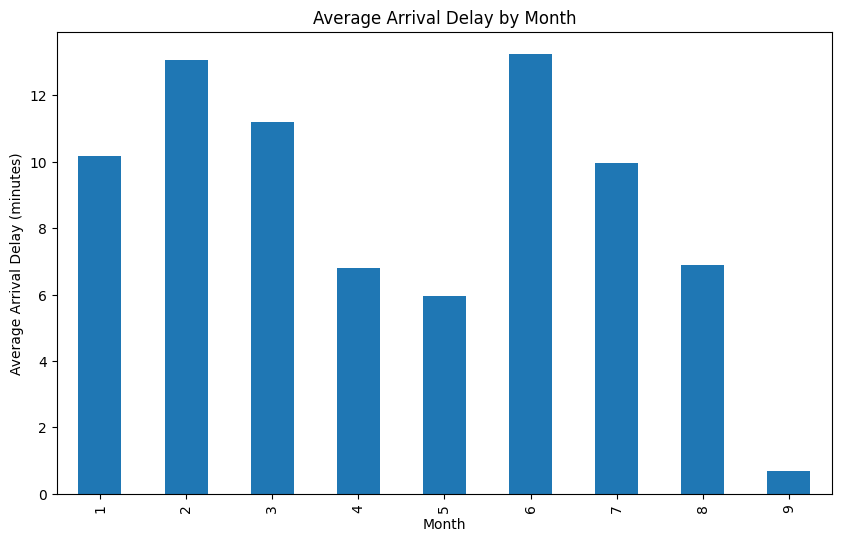

In [84]:
# Correlation of DayofMonth with ArrDelay
corr_dayofmonth = train_df['Month'].corr(df['ArrDelay'])
print(f"Correlation between Month and ArrDelay: {corr_dayofmonth:.4f}")

# Check average delay for each day of the month
avg_delay_by_day = train_df.groupby('Month')['ArrDelay'].mean()
print(avg_delay_by_day)

# Optional: Plot the average delay by day of the month
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
avg_delay_by_day.plot(kind='bar')
plt.title("Average Arrival Delay by Month")
plt.xlabel("Month")
plt.ylabel("Average Arrival Delay (minutes)")
plt.show()


I am using non-linear model, I will can keep Month to allow the model to learn the higher delays observed in certain months like June and December.

In [86]:
train_df.to_csv('train_cleaned.csv', index=False)
val_df.to_csv('val_cleaned.csv', index=False)
test_df.to_csv('test_cleaned.csv', index=False)

### Checkpoint

In [22]:
df = pd.read_csv('time_cleaned_dataset_hhmm_removed_routeavg_too.csv')

### Import the Gradient Boost Algorith Model: Catboost

In [85]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count


# Check if GPUs are available
gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"CatBoost detected {gpu_count} GPU(s). GPU training is available.")
else:
    print("No GPUs detected. CatBoost will use CPU.")


CatBoost detected 1 GPU(s). GPU training is available.


In [89]:
import pandas as pd
from catboost import CatBoostClassifier, Pool

# Assuming df is your preprocessed DataFrame
# First, define the target variable (for example, flights delayed 15+ minutes)
df['Delayed'] = (df['ArrDelay'] > 15).astype(int)
# add delayed column to the datasets 
train_df['Delayed'] = (train_df['ArrDelay'] > 15).astype(int)
val_df['Delayed'] = (val_df['ArrDelay'] > 15).astype(int)
test_df['Delayed'] = (test_df['ArrDelay'] > 15).astype(int)
# If you want a smaller training subset for quick iteration:
train_sample_df = train_df.sample(frac=0.01, random_state=42)

# Define features and target
target = 'Delayed'
features = [col for col in train_df.columns if col not in [target, 'ArrDelay', ]]  # exclude target and original delay if not needed
print(features)
# Identify categorical features for CatBoost
categorical_features = ['UniqueCarrier','Route', 'Origin', 'Dest']
# Make sure these categorical columns exist in your dataset and contain appropriate string or categorical values


['Year', 'Month', 'UniqueCarrier', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiOut', 'Cancelled', 'IsWeekday', 'Route', 'DepTime_hour', 'DepTime_minute', 'CRSDepTime_hour', 'CRSDepTime_minute', 'ArrTime_hour', 'ArrTime_minute', 'CRSArrTime_hour', 'CRSArrTime_minute', 'CarrierAvgDelay', 'RouteAvgDelay']


In [90]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Convert data into CatBoost Pool objects
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

# Initialize the CatBoost classifier with GPU support
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    eval_metric='F1',
    random_seed=42,
    verbose=100,
    task_type='GPU'  # Ensure GPU usage
)

# Train the model using the training and validation sets
model.fit(
    train_pool,
    eval_set=val_pool,
    early_stopping_rounds=50,
    verbose = True
)

# Get the model's parameters
params = model.get_params()

# Retrieve the 'task_type' parameter
task_type = params.get('task_type', 'CPU')

# Print the device type
print("CatBoost task type:", task_type)

# # Optionally, you can uncomment to train and fine-tune using the smaller subset before training on the full dataset:
# sample_train_pool = Pool(data=train_sample_df[features], label=train_sample_df[target], cat_features=categorical_features)
# model.fit(sample_train_pool, eval_set=val_pool, early_stopping_rounds=50)

# press any key to continue
input("Press for test predictions...")
# Evaluate the model on the test set
test_predictions = model.predict(test_pool)
test_probas = model.predict_proba(test_pool)[:,1]


# Evaluate metrics
accuracy = accuracy_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_probas)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

# Feature importance
feature_importances = model.get_feature_importance()
for col, imp in zip(features, feature_importances):
    print(f"Feature: {col}, Importance: {imp}")


0:	learn: 0.8300804	test: 0.7866406	best: 0.7866406 (0)	total: 807ms	remaining: 13m 26s
1:	learn: 0.8311616	test: 0.7866769	best: 0.7866769 (1)	total: 1.56s	remaining: 13m
2:	learn: 0.8331036	test: 0.7898414	best: 0.7898414 (2)	total: 2.35s	remaining: 13m 1s
3:	learn: 0.8357263	test: 0.7928996	best: 0.7928996 (3)	total: 3.11s	remaining: 12m 55s
4:	learn: 0.8375079	test: 0.7952566	best: 0.7952566 (4)	total: 3.92s	remaining: 13m
5:	learn: 0.8379476	test: 0.7965886	best: 0.7965886 (5)	total: 4.74s	remaining: 13m 5s
6:	learn: 0.8377235	test: 0.7960156	best: 0.7965886 (5)	total: 5.51s	remaining: 13m 1s
7:	learn: 0.8394098	test: 0.7978894	best: 0.7978894 (7)	total: 6.3s	remaining: 13m 1s
8:	learn: 0.8401287	test: 0.7992107	best: 0.7992107 (8)	total: 7.28s	remaining: 13m 21s
9:	learn: 0.8419358	test: 0.8014256	best: 0.8014256 (9)	total: 8.12s	remaining: 13m 23s
10:	learn: 0.8425876	test: 0.8023430	best: 0.8023430 (10)	total: 9.2s	remaining: 13m 47s
11:	learn: 0.8426128	test: 0.8019011	best: 0

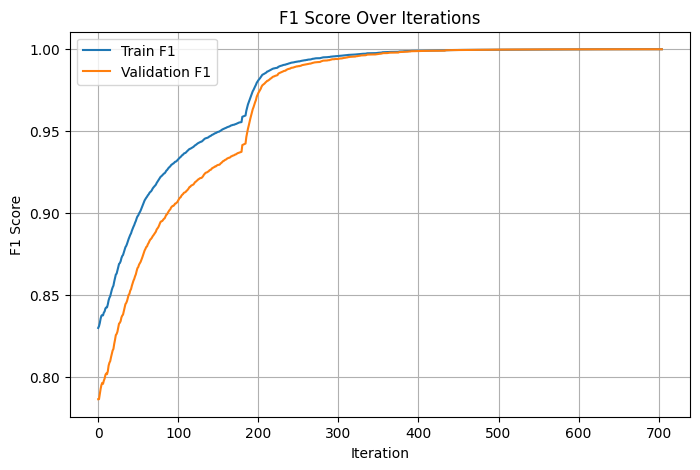

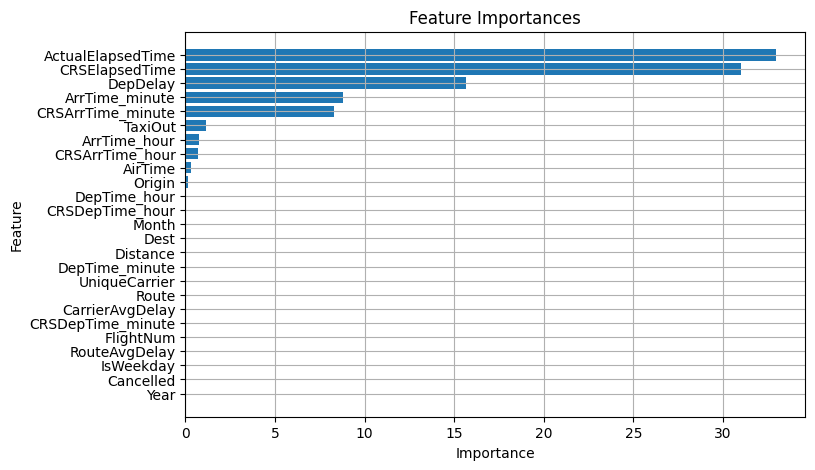

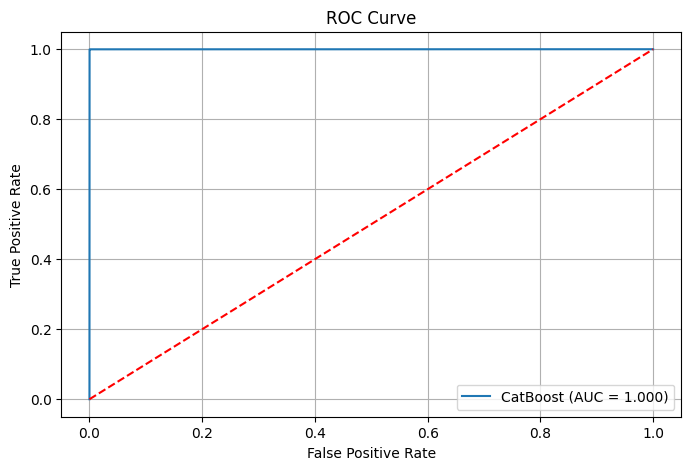

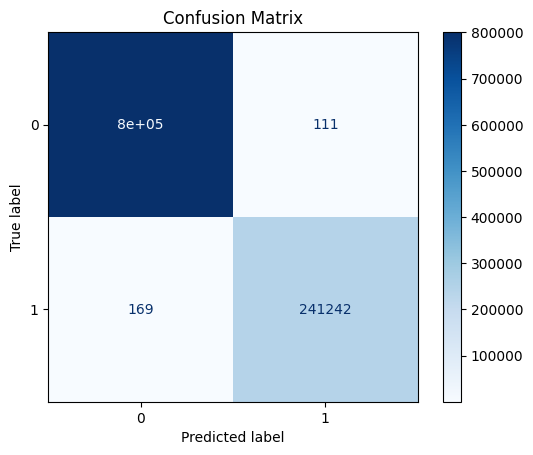

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Retrieve evaluation results for plotting training vs. validation metrics
evals_result = model.get_evals_result()
train_f1 = evals_result['learn']['F1']
val_f1 = evals_result['validation']['F1']

plt.figure(figsize=(8,5))
plt.plot(train_f1, label='Train F1')
plt.plot(val_f1, label='Validation F1')
plt.title('F1 Score Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance plot
plt.figure(figsize=(8,5))
sorted_idx = np.argsort(feature_importances)
plt.barh([features[i] for i in sorted_idx], [feature_importances[i] for i in sorted_idx])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, test_probas)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label='CatBoost (AUC = {:.3f})'.format(roc_auc))
plt.plot([0,1], [0,1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
